<h1 align=center><font size = 5>Capstone Project - The Battle of Neighborhoods</font></h1>

## Introduction

When we decide to visit a country, we may need lots of information pertaining to some target places, i.e. a city, scenery, or national park, etc. In this project, I’d like to develop a system to help tourists visit Taipei City which is the capital and a special municipality of Taiwan. By analyzing the 12 administrative districts in the Taipei City, including Songshan, Xinyi, Daan, Zhongshan, Zhongzheng, Datong, Wanhua, Wenshan, Nangang, Neihu, Shilin, and Beitou, tourists may have initial knowledge of Taipei City which may help them to organize their itinerary. Moreover, when we plan a journey, we may search where to stay with online marketplaces and filter out lots of searches. To help people make a decision more easily, the system will show the regional characteristics with the Foursquare data pertaining to a short list of accommodation choices. More specifically, the project will  provide a function that analyzes the data obtained from Foursquare and assists people to search as well as decide the accommodations when they are traveling, especially, in Taipei.

## Objective

In this project, we will know more about the details of districts in Taipei through machine learning segmentation and clustering. Second, by input a short list of accommodation addresses, we can apply this project to analyze the characteristics of surrounding venues with Foursquare data and K-means and help us to look for accommodations according to our preferences. By means of segmentation and clustering as well as Foursquare data, the following goals are expected to be fulfilled:
1. Analyze the districts in Taipei
2. Recommend the ordered accommodations from the aspect of the specified attributes.

## Data

The district data of Taipei City is scraped from a table on the wikipedia page “https://en.wikipedia.org/wiki/Taipei”, which contains the English name, Chinese name, pinyin, population, area, and postal code of each district in Taipei City. After data wrangling, the columns of district data will be English name, Chinese name, population, and area left. For the second objective, a short list of accommodation addresses is prepared in text file format and uploaded to my github for reference “https://github.com/allisonyuplayground/Coursera_Capstone/blob/master/accommodation_list.txt”. Each address is stored in a single line of the text file, so that an user can extract a list of addresses by reading the file line by line and storing them into an array. Another aspect of this project is the Foursquare data, such as venue name, venue category, venue latitude, venue longitude, etc., which are mainly used for segmentation and clustering.

## Methodology

### Analyze the districts in Taipei - data wrangling

In [313]:
import numpy as np
import pandas as pd
pd.set_option( 'display.max_columns', None )
pd.set_option( 'display.max_rows', None )

df = pd.read_html( "https://en.wikipedia.org/wiki/Taipei" )[8]

# Drop the first and second rows that we don't need
df.drop( df.columns[[0, 1]], axis = 0, inplace = True )

# Shift left by one column of the row index 2
df.loc[[2]] = df.loc[[2]].shift( -1, axis = 1 )

# Drop the columns we don't need
df.drop( df.columns[[2, 3, 4, 8]], axis = 1, inplace = True )

# Fill the missing value
df.loc[[2], [5]] = 257922

# Reset the row indexes
df.reset_index( drop = True, inplace = True )

# Define the dataframe columns
df.columns = ['eng_name', 'cn_name', 'population', 'area_km2', 'postal_code']

# Convert data into expected format
print( "The data type of column 'postal_code' and 'population' are '{}' and '{}' originally.".format( df['postal_code'].dtype, df['population'].dtype ) )
df['postal_code'] = df['postal_code'].astype( np.int64 )
df['population'] = df['population'].astype( np.int64 )
print( "The data type of column 'postal_code' and 'population' are '{}' and '{}' now.".format( df['postal_code'].dtype, df['population'].dtype ) )

# Let's check the dataframe
df

The data type of column 'postal_code' and 'population' are 'float64' and 'object' originally.
The data type of column 'postal_code' and 'population' are 'int64' and 'int64' now.


,eng_name,cn_name,population,area_km2,postal_code
0,Beitou,北投區,257922,56.8216,112
1,Da'an,大安區,312909,11.3614,106
2,Datong,大同區,131029,5.6815,103
3,Nangang,南港區,122296,21.8424,115
4,Neihu,內湖區,287726,31.5787,114
5,Shilin,士林區,290682,62.3682,111
6,Songshan,松山區,209689,9.2878,105
7,Wanhua,萬華區,194314,8.8522,108
8,Wenshan,文山區,275433,31.5090,116
9,Xinyi,信義區,229139,11.2077,110


Use geopy library to get the latitude and longitude values of each district for further use. Through geopy package, the latitude and longitude values of each district can be obtained.

In [395]:
from geopy.geocoders import Nominatim

geolocator = Nominatim( user_agent = "my-application", timeout = 15 )

# Obtain the latitude and longitude values of Taipei City
tp_location = geolocator.geocode( "Taipei City, Taiwan" )
tp_lat = tp_location.latitude
tp_lng = tp_location.longitude
print( "The geograpical coordinate of {:<10} are {:<10}, {}".format( "Taipei City", tp_lat, tp_lng ) )

# Create a functino to obtain the latitude and longitude values of all districts iteratively
def getGeoCoordinate( address_list ):
    latitude = []
    longitude = []
    for idx, d in enumerate( address_list ):
        location = geolocator.geocode( d )
        try:
            latitude.append( location.latitude )
            longitude.append( location.longitude )
        except:
            latitude.append( location[-1][0] )
            longitude.append( location[-1[0]] )
        print( "The geograpical coordinate of '{:<11}' are {:<10}, {}".format( d, latitude[-1], longitude[-1] ) )
    return { "latitude": latitude, "longitude": longitude }

# Convert a column into a list
district_list = list( df.loc[:, ['eng_name']].T.as_matrix()[0] + " District, Taipei City, Taiwan" )

# Add two new columns from list latitude and list longitude
coordinates = getGeoCoordinate( district_list )
df['lat'] = np.asarray( coordinates["latitude"] )
df['lng'] = np.asarray( coordinates["longitude"] )

# Quickly examine the resulting dataframe
district_count = df.shape[0]
print( "df.shape = {} means there are {} districts and {} attributes".format( df.shape, district_count, df.shape[1] ) )
df

The geograpical coordinate of Taipei City are 25.0375198, 121.5636796
The geograpical coordinate of 'Beitou District, Taipei City, Taiwan' are 25.1319307, 121.4985934
The geograpical coordinate of 'Da'an District, Taipei City, Taiwan' are 25.0265152, 121.534395
The geograpical coordinate of 'Datong District, Taipei City, Taiwan' are 25.065986 , 121.515514
The geograpical coordinate of 'Nangang District, Taipei City, Taiwan' are 25.0545779, 121.6065999
The geograpical coordinate of 'Neihu District, Taipei City, Taiwan' are 25.069664 , 121.5889983
The geograpical coordinate of 'Shilin District, Taipei City, Taiwan' are 25.0918396, 121.5242068
The geograpical coordinate of 'Songshan District, Taipei City, Taiwan' are 25.0498852, 121.5772719
The geograpical coordinate of 'Wanhua District, Taipei City, Taiwan' are 25.0319327, 121.4993322
The geograpical coordinate of 'Wenshan District, Taipei City, Taiwan' are 24.989786 , 121.570458
The geograpical coordinate of 'Xinyi District, Taipei City

,eng_name,cn_name,population,area_km2,postal_code,lat,lng
0,Beitou,北投區,257922,56.8216,112,25.131931,121.498593
1,Da'an,大安區,312909,11.3614,106,25.026515,121.534395
2,Datong,大同區,131029,5.6815,103,25.065986,121.515514
3,Nangang,南港區,122296,21.8424,115,25.054578,121.606600
4,Neihu,內湖區,287726,31.5787,114,25.069664,121.588998
5,Shilin,士林區,290682,62.3682,111,25.091840,121.524207
6,Songshan,松山區,209689,9.2878,105,25.049885,121.577272
7,Wanhua,萬華區,194314,8.8522,108,25.031933,121.499332
8,Wenshan,文山區,275433,31.5090,116,24.989786,121.570458
9,Xinyi,信義區,229139,11.2077,110,25.033345,121.566896


Create a map of Taipei City with districts superimposed on top.

In [571]:
import folium

# Create a map of Taipei City using latitude and longitude values
map_tp = folium.Map( location = [tp_lat, tp_lng], zoom_start = 12 )

# add markers to map
for lat, lng, cn_name, eng_name in zip( df['lat'], df['lng'], df['cn_name'], df['eng_name'] ):
    label = '{}, {}'.format( cn_name, eng_name )
    label = folium.Popup( label, parse_html = True )
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7 ).add_to( map_tp )

map_tp

Next, we are going to start utilizing the Foursquare API to explore the characteristics of each district and segment them for tourists.

### Analyze the districts in Taipei - data exploration

In [428]:
import requests

# Define Foursquare Credentials and Version
CLIENT_ID = '2MS4P4ZWPKO5Z1J3RTRRGNFCUJIFRBBVEKMBGW5UGJ1BJPZQ'
CLIENT_SECRET = 'OUGLQ2FMLEQPGS0TR2ATZTK03C3L2UHSSFEKCB3VRH41DTRS'
VERSION = '20181105'

print( "My credentials" )
print( "CLIENT_ID: {}".format( CLIENT_ID ) )
print( "CLIENT_SECRET: {}".format( CLIENT_SECRET ) )

My credentials
CLIENT_ID: 2MS4P4ZWPKO5Z1J3RTRRGNFCUJIFRBBVEKMBGW5UGJ1BJPZQ
CLIENT_SECRET: OUGLQ2FMLEQPGS0TR2ATZTK03C3L2UHSSFEKCB3VRH41DTRS


Now, I'm going to create a function to repeat a same process to all districts in Taipei. The aim of this function is to get the top 100 venues that are in each district within a radius of 800 meters. By executing the function getNearbyVenues() on each neighborhood, the venues searched from Foursqure database will be returned in a new dataframe.

In [429]:
RADIUS = 800 # Meters
LIMIT = 100 # Max amount of venues to be searched

def getNearbyVenues( latitudes, longitudes, eng_names, radius = RADIUS, limit = LIMIT ):
    venues = []

    # Get the latitude and logitude of districts
    for lat, lng, eng_name in zip( latitudes, longitudes, eng_names ):
        # Create the GET request URL with the latitude and longitude values of each district
        url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
              CLIENT_ID,
              CLIENT_SECRET,
              VERSION,
              lat,
              lng,
              radius,
              limit )

        # Send the GET request
        results = requests.get( url ).json()['response']['groups'][0]['items']
        print( "There are {:>3} top venues searched within {} meters in {:>10} district".format( len( results ), radius, eng_name ) )

        # Return only relevant information for each nearby venue
        venues.append( [( eng_name,
                          v['venue']['name'],
                          v['venue']['location']['lat'],
                          v['venue']['location']['lng'],
                          v['venue']['location']['distance'],
                          v['venue']['categories'][0]['name'] ) for v in results] )
        
    tp_venues = pd.DataFrame( [item for venue_list in venues for item in venue_list] )
    tp_venues.columns = ['district', 'v_name', 'v_lat', 'v_lng', 'v_dis', 'category']
    return tp_venues

# Call the above method to get the venue data
tp_venues = getNearbyVenues( latitudes = df['lat'],
                             longitudes = df['lng'],
                             eng_names = df['eng_name'] )

There are  34 top venues searched within 800 meters in     Beitou district
There are 100 top venues searched within 800 meters in      Da'an district
There are  50 top venues searched within 800 meters in     Datong district
There are  29 top venues searched within 800 meters in    Nangang district
There are  13 top venues searched within 800 meters in      Neihu district
There are  68 top venues searched within 800 meters in     Shilin district
There are  31 top venues searched within 800 meters in   Songshan district
There are  47 top venues searched within 800 meters in     Wanhua district
There are  30 top venues searched within 800 meters in    Wenshan district
There are 100 top venues searched within 800 meters in      Xinyi district
There are  56 top venues searched within 800 meters in  Zhongshan district
There are  61 top venues searched within 800 meters in Zhongzheng district


In [430]:
# Check the size of the resulting dataframe
print( "1. tp_venues.shape is {}, that is, there are {} venues returned.".format( tp_venues.shape, tp_venues.shape[0] ) )

# Find out how many unique categories can be curated from all the returned venues
print( "\n2. There are {} uniques categories.".format( len( tp_venues['category'].unique() ) ) )

# Check how many venues were returned for each district
print( "\n3. Here is the amount of returned venues for each district:" )
tp_venues.groupby( 'district' ).count()

1. tp_venues.shape is (619, 6), that is, there are 619 venues returned.

2. There are 133 uniques categories.

3. Here is the amount of returned venues for each district:


,v_name,v_lat,v_lng,v_dis,category
district,,,,,
Beitou,34,34,34,34,34
Da'an,100,100,100,100,100
Datong,50,50,50,50,50
Nangang,29,29,29,29,29
Neihu,13,13,13,13,13
Shilin,68,68,68,68,68
Songshan,31,31,31,31,31
Wanhua,47,47,47,47,47
Wenshan,30,30,30,30,30


Create a map of Taipei City with the returned venues superimposed on top.

In [431]:
# Create a map of Taipei City with venues superimposed on top.
map_tp = folium.Map( location = [tp_lat, tp_lng], zoom_start = 12 )

# Visualize the exploration neighborhoods of Foursqure
for cn_name, eng_name, lat, lng in zip( df['cn_name'], df['eng_name'], df['lat'], df['lng'] ):
    label = "{}, {} district".format( cn_name, eng_name )
    label = folium.Popup( label, parse_html = True )
    folium.Circle( [lat, lng],
                   radius = RADIUS,
                   popup = label,
                   color = '#082270',
                   fill = True,
                   fill_color = '#082270',
                   fill_opacity = 0.5 ).add_to( map_tp )
    
# Add venue markers to map
for lat, lng, v_name, category in zip( tp_venues['v_lat'], tp_venues['v_lng'], tp_venues['v_name'], tp_venues['category'] ):
    label = "{}, {}".format( v_name, category )
    label = folium.Popup( label, parse_html = True )
    folium.CircleMarker( [lat, lng],
                         radius = 3,
                         popup = label,
                         color = '#0279e8',
                         fill = True,
                         fill_color = '#e0f0ff',
                         fill_opacity = 0.9 ).add_to( map_tp )
map_tp

In [434]:
# Check the dataframe returned from the function getNearbyVenues()
tp_venues.head()

,district,v_name,v_lat,v_lng,v_dis,category,category_2
0,Beitou,蔡元益紅茶（總店）,25.131896,121.502012,344,Tea Room,dessert shop
1,Beitou,阿馬非 Coffee. Pizza.pasta,25.132340,121.497882,85,Italian Restaurant,food shop
2,Beitou,傳統之最豆花堂,25.133637,121.498719,190,Dessert Shop,dessert shop
3,Beitou,Beitou Park (北投公園),25.136605,121.504432,785,Park,tourist spot
4,Beitou,張吳記什錦麵,25.127777,121.500023,484,Noodle House,food shop


### Analyze the districts in Taipei - Characteristic analysis of Taipei districts

Next, create a function to convert some categories into expected types.

In [435]:
new_category = ['coffee shop', 'dessert shop', 'food shop', 'leisure place', 'hotel', 'shop', 'tourist spot', 'bar']
def cvtCategory( ori_category ):
    if any( ele in ori_category.lower() for ele in ['café', 'coffee shop'] ):
        ori_category = new_category[0]
    if any( ele in ori_category.lower() for ele in ['ice cream', 'snack', 'dessert shop', 'tea', 'bake', 'fried chicken joint', 'hot dog joint', 'burger joint', 'food truck'] ):
        ori_category = new_category[1]
    if any( ele in ori_category.lower() for ele in ['restaurant', 'soup', 'noodle', 'breakfast', 'deli', 'diner', 'pizza', 'brewery', 'bbq', 'food court', 'food stand', 'chaan teng', 'sandwich', 'bistro', 'bagel'] ):
        ori_category = new_category[2]
    if any( ele in ori_category.lower() for ele in ['theater', 'playground', 'gym', 'laser tag', 'bowling', 'multiplex', 'massage', 'play area'] ):
        ori_category = new_category[3]
    if any( ele in ori_category.lower() for ele in ['hotel', 'hostel', 'boarding house'] ):
        ori_category = new_category[4]
    if any( ele in ori_category.lower() for ele in ['duty-free', 'market', 'mall', 'store', 'plaza', 'boutique', 'pharmacy', 'record shop', 'motorcycle shop', 'sporting goods shop', 'cheese shop'] ):
        ori_category = new_category[5]
    if any( ele in ori_category.lower() for ele in ['museum', 'monument', 'planetarium', 'hall', 'historic site', 'building', 'art', 'scenic', 'station', 'bridge', 'park', 'garden', 'spring', 'temple'] ):
        ori_category = new_category[6]
    if any( ele in ori_category.lower() for ele in ['bar', 'club', 'lounge', 'speakeasy'] ):
        ori_category = new_category[7]
    return ori_category

# Convert category types and add into a new column
tp_venues['category_2'] = tp_venues[['category']].apply( lambda x: cvtCategory( *x ), axis = 1 )

# Find out how many unique categories left from all the venues
print( "There are {} unique categories in column 'category'".format( len( tp_venues['category'].unique() ) ) )
print( "There are {} unique categories in column 'category_2'.".format( len( tp_venues['category_2'].unique() ) ) )

# Remove the venues that are not in the new_category
tp_df = tp_venues[tp_venues['category_2'].isin( new_category )]
print( "\nThe shape of new venue dataframe in expected category: {}".format( tp_df.shape ) )

There are 133 unique categories in column 'category'
There are 11 unique categories in column 'category_2'.

The shape of new venue dataframe in expected category: (612, 7)


Analyze each district from the dataframe tp_df.

In [436]:
# One hot encoding
tp_onehot = pd.get_dummies( tp_df[['category_2']], prefix = "", prefix_sep = "" )

# Add district column back to dataframe
tp_onehot['district'] = tp_df['district']
tp_onehot['ori_category'] = tp_df['category']

# Move district and category column to the first and second columns
fixed_columns = [tp_onehot.columns[-2], tp_onehot.columns[-1]] + list( tp_onehot.columns[:-2] )
tp_onehot = tp_onehot[fixed_columns]

# Check the new dataframe tp_onehot
print( "tp_onehot.shape = {}".format( tp_onehot.shape ) )
tp_onehot.head()

tp_onehot.shape = (612, 10)


,district,ori_category,bar,coffee shop,dessert shop,food shop,hotel,leisure place,shop,tourist spot
0,Beitou,Tea Room,0,0,1,0,0,0,0,0
1,Beitou,Italian Restaurant,0,0,0,1,0,0,0,0
2,Beitou,Dessert Shop,0,0,1,0,0,0,0,0
3,Beitou,Park,0,0,0,0,0,0,0,1
4,Beitou,Noodle House,0,0,0,1,0,0,0,0


Group rows by district and by taking the mean of the frequency of occurrence of each category which specified by us previously. After grouping the data, we can use the bar plot to visualize the frequency distribution of venue categories for each district.

In [545]:
tp_grouped = tp_onehot.groupby( 'district' ).mean().reset_index()

# Add venue density for further use
tp_grouped['venue_density'] = ( tp_venues.groupby( 'district' ).count()['v_name'] / ( ( RADIUS * 0.001 ) * ( RADIUS * 0.001 ) ) ).values
tp_grouped
#tp_venues.groupby( 'district' ).count()['v_name'] / ( ( RADIUS * 0.001 ) * ( RADIUS * 0.001 ) )

,district,bar,coffee shop,dessert shop,food shop,hotel,leisure place,shop,tourist spot,venue_density
0,Beitou,0.000000,0.181818,0.151515,0.242424,0.090909,0.060606,0.090909,0.181818,69.387755
1,Da'an,0.030303,0.323232,0.111111,0.353535,0.010101,0.020202,0.121212,0.030303,204.081633
2,Datong,0.040816,0.163265,0.102041,0.387755,0.020408,0.020408,0.183673,0.081633,102.040816
3,Nangang,0.000000,0.206897,0.068966,0.379310,0.068966,0.034483,0.206897,0.034483,59.183673
4,Neihu,0.000000,0.153846,0.076923,0.307692,0.076923,0.076923,0.307692,0.000000,26.530612
5,Shilin,0.029851,0.134328,0.194030,0.328358,0.029851,0.059701,0.179104,0.044776,138.775510
6,Songshan,0.000000,0.033333,0.033333,0.500000,0.066667,0.033333,0.233333,0.100000,63.265306
7,Wanhua,0.021277,0.106383,0.212766,0.361702,0.042553,0.000000,0.170213,0.085106,95.918367
8,Wenshan,0.000000,0.300000,0.066667,0.400000,0.000000,0.033333,0.166667,0.033333,61.224490
9,Xinyi,0.080808,0.080808,0.060606,0.414141,0.030303,0.040404,0.222222,0.070707,204.081633


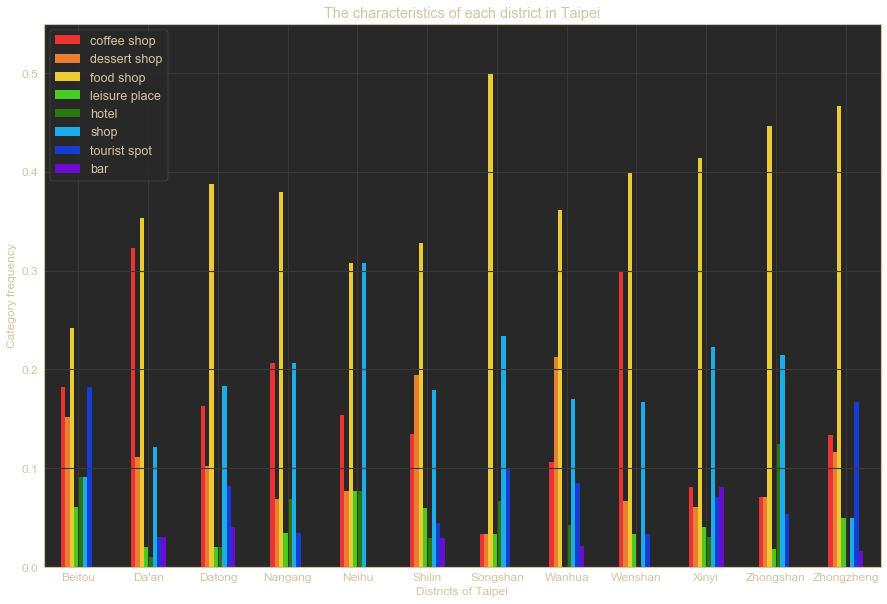

In [438]:
import matplotlib.pyplot as plt
% matplotlib inline

colors = ['#ea3333','#ea7f33','#eacb33','#49cc21', '#287a0f','#1cacea','#173cd3','#6b0cd1']
ax = tp_grouped[new_category].plot( kind = 'bar',
                                    title = "The characteristics of each district in Taipei",
                                    figsize = ( 15, 10 ),
                                    legend = True,
                                    fontsize = 12,
                                    color = colors )
ax.set_xlabel( "Districts of Taipei", fontsize = 12 )
ax.set_ylabel( "Category frequency", fontsize = 12 )
ax.set_xticklabels( tp_grouped['district'], rotation = 0, fontsize = 12 )
ax.margins( 0.1 )
plt.show()

### Analyze the districts in Taipei - K-means clustering

Run k-means to cluster the neighborhood into 3 clusters

In [546]:
from sklearn.cluster import KMeans
K_CLUSTER = 3
kmeans = KMeans( n_clusters = K_CLUSTER, random_state = 0 ).fit( tp_grouped[new_category + ['venue_density']] )

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 2, 0, 1, 1, 0, 1, 0, 1, 2, 0, 0], dtype=int32)

### Analyze the districts in Taipei - Data aggregation

Next, sort venues for districts respectively and join the analyzed data into the first dataframe df as df_joined. Also add clustering results by k-means into df_joined.

In [558]:
# Prepare the new column names
temp_columns = ['district']
for idx in np.arange( len( new_category ) ):
    temp_columns.append( '{}_common_venue'.format( idx + 1 ) )

# Create a function to sort venues for Taipei districts respectively, and return lists of lists structure
def sort_rows_by_freq( data, columns ):
    res_list = []
    for idx in range( 0, data.shape[0], 1 ):
        v_sorted = data.loc[[idx], columns].sort_values( by = idx, ascending = False, axis = 1 )
        # Append the distrct name and its sorted venues
        res_list.append( list( data.loc[[idx], 'district'].values ) + v_sorted.columns.tolist() )
    return res_list

# Execute venue sorting and store into a dataframe
temp_data = sort_rows_by_freq( tp_grouped, new_category )
temp_df = pd.DataFrame( temp_data, columns = temp_columns )
df_joined = df.join( temp_df.set_index( 'district' ), on = 'eng_name' )

# Add clustering labels
df_joined['cluster_label'] = kmeans.labels_

# Add venue density
df_joined['venue_density'] = tp_grouped['venue_density'].values

df_joined

,eng_name,cn_name,population,area_km2,postal_code,lat,lng,1_common_venue,2_common_venue,3_common_venue,4_common_venue,5_common_venue,6_common_venue,7_common_venue,8_common_venue,cluster_label,venue_density
0,Beitou,北投區,257922,56.8216,112,25.131931,121.498593,food shop,coffee shop,tourist spot,dessert shop,hotel,shop,leisure place,bar,1,69.387755
1,Da'an,大安區,312909,11.3614,106,25.026515,121.534395,food shop,coffee shop,shop,dessert shop,tourist spot,bar,leisure place,hotel,2,204.081633
2,Datong,大同區,131029,5.6815,103,25.065986,121.515514,food shop,shop,coffee shop,dessert shop,tourist spot,bar,leisure place,hotel,0,102.040816
3,Nangang,南港區,122296,21.8424,115,25.054578,121.606600,food shop,coffee shop,shop,dessert shop,hotel,leisure place,tourist spot,bar,1,59.183673
4,Neihu,內湖區,287726,31.5787,114,25.069664,121.588998,food shop,shop,coffee shop,dessert shop,leisure place,hotel,tourist spot,bar,1,26.530612
5,Shilin,士林區,290682,62.3682,111,25.091840,121.524207,food shop,dessert shop,shop,coffee shop,leisure place,tourist spot,hotel,bar,0,138.775510
6,Songshan,松山區,209689,9.2878,105,25.049885,121.577272,food shop,shop,tourist spot,hotel,coffee shop,dessert shop,leisure place,bar,1,63.265306
7,Wanhua,萬華區,194314,8.8522,108,25.031933,121.499332,food shop,dessert shop,shop,coffee shop,tourist spot,hotel,bar,leisure place,0,95.918367
8,Wenshan,文山區,275433,31.5090,116,24.989786,121.570458,food shop,coffee shop,shop,dessert shop,leisure place,tourist spot,hotel,bar,1,61.224490
9,Xinyi,信義區,229139,11.2077,110,25.033345,121.566896,food shop,shop,coffee shop,bar,tourist spot,dessert shop,leisure place,hotel,2,204.081633


Visualize the map with the clustering results.

In [559]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# Create a map of Taipei City with venues superimposed on top.
map_tp = folium.Map( location = [tp_lat, tp_lng], zoom_start = 12 )

# set color scheme for the clusters
x = np.arange( K_CLUSTER )
ys = [i + x + ( i * x ) ** 2 for i in range( K_CLUSTER )]
colors_array = cm.jet( np.linspace( 0, 1, len( ys ) ) )
rainbow = [colors.rgb2hex( i ) for i in colors_array]

# Visualize the exploration neighborhoods of Foursqure
for cn_name, eng_name, lat, lng, cluster in zip( df_joined['cn_name'], df_joined['eng_name'], df_joined['lat'], df_joined['lng'], df_joined['cluster_label'] ):
    label = "{}, {} district, cluster: {}".format( cn_name, eng_name, cluster )
    label = folium.Popup( label, parse_html = True )
    folium.Circle( [lat, lng],
                   radius = RADIUS,
                   popup = label,
                   color = rainbow[cluster - 1],
                   fill = True,
                   fill_color = rainbow[cluster - 1],
                   fill_opacity = 0.7 ).add_to( map_tp )
    
# Add venue markers to map
for lat, lng, v_name, category in zip( tp_venues['v_lat'], tp_venues['v_lng'], tp_venues['v_name'], tp_venues['category'] ):
    label = "{}, {}".format( v_name, category )
    label = folium.Popup( label, parse_html = True )
    folium.CircleMarker( [lat, lng],
                         radius = 3,
                         popup = label,
                         color = '#0279e8',
                         fill = True,
                         fill_color = '#e0f0ff',
                         fill_opacity = 0.9 ).add_to( map_tp )
map_tp

### Recommend the ordered accommodations from the aspect of the specified attributes

In [552]:
print( "Attribute: {}".format( new_category ) )

# Read address from the given text file
with open( 'accommodation_list.txt', 'r') as f:
    content = f.readlines()
addresses = [x.strip().replace( "No.", "" ).\
                       replace( "Rd.", "Road" ).\
                       replace( "Dist.", "District" ).\
                       replace( ", R.O.C.", "" ) for x in content] 
print( "Accommodation: {}".format( addresses ) )

Attribute: ['coffee shop', 'dessert shop', 'food shop', 'leisure place', 'hotel', 'shop', 'tourist spot', 'bar']
Accommodation: ['38, Songren Road, Xinyi District, Taipei City Taiwan', '55, Lequn 2nd Road, Zhongshan District, Taipei 10462, Taiwan', 'Regent Taipei']


In [567]:
import requests

data_dict = { 'accommodation_choice': ["choice_{}".format( i ) for i in range( 0, len( addresses ), 1 )] }
data_dict['address'] = addresses

# Get geograpical coordinates of the listed addresses
data_dict.update( getGeoCoordinate( addresses ) )
# Now, we have 4 keys: accommodation_choice, address, latitude, longitude

# Define Foursquare Credentials and Version
CLIENT_ID = '2MS4P4ZWPKO5Z1J3RTRRGNFCUJIFRBBVEKMBGW5UGJ1BJPZQ'
CLIENT_SECRET = 'OUGLQ2FMLEQPGS0TR2ATZTK03C3L2UHSSFEKCB3VRH41DTRS'
VERSION = '20181105'
RADIUS = 700 # meters
LIMIT = 100

# Explore a list of recommended venues near the current location
v = []
for lat, lng, choice in zip( data_dict['latitude'], data_dict['longitude'], data_dict['accommodation_choice'] ):
    # Create the GET request URL with the latitude and longitude values
    url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
              CLIENT_ID,
              CLIENT_SECRET,
              VERSION,
              lat,
              lng,
              RADIUS,
              LIMIT )

    # Send the GET request
    results = requests.get( url ).json()['response']['groups'][0]['items']
    print( "There are {:>3} top venues searched within {} meters in {}".format( len( results ), RADIUS, choice ) )

    # Return only relevant information for each nearby venue
    v.append( [( choice,
                 res['venue']['name'],
                 res['venue']['location']['lat'],
                 res['venue']['location']['lng'],
                 res['venue']['location']['distance'],
                 res['venue']['categories'][0]['name'] ) for res in results] )
v_df = pd.DataFrame( [item for v_list in v for item in v_list] )
v_df.columns = ['choice', 'v_name', 'v_lat', 'v_lng', 'v_dis', 'category']

# Create a map with venues superimposed on top.
c_latitude = sum( data_dict['latitude'] ) / float( len( data_dict['latitude'] ) )
c_longitude = sum( data_dict['longitude'] ) / float( len( data_dict['longitude'] ) )
map_accommodation = folium.Map( location = [c_latitude, c_longitude], zoom_start = 13 )

# Visualize the exploration neighborhoods of Foursqure
for choice, address, lat, lng in zip( data_dict['accommodation_choice'], data_dict['address'], data_dict['latitude'], data_dict['longitude'] ):
    label = "{}: {}".format( choice, address )
    label = folium.Popup( label, parse_html = True )
    folium.Circle( [lat, lng],
                   radius = RADIUS,
                   popup = label,
                   color = '#082270',
                   fill = True,
                   fill_color = '#082270',
                   fill_opacity = 0.5 ).add_to( map_accommodation )
    
# Add venue markers to map
for lat, lng, v_name, category in zip( v_df['v_lat'], v_df['v_lng'], v_df['v_name'], v_df['category'] ):
    label = "{}, {}".format( v_name, category )
    label = folium.Popup( label, parse_html = True )
    folium.CircleMarker( [lat, lng],
                         radius = 3,
                         popup = label,
                         color = '#0279e8',
                         fill = True,
                         fill_color = '#e0f0ff',
                         fill_opacity = 0.9 ).add_to( map_accommodation )
map_accommodation

The geograpical coordinate of '38, Songren Road, Xinyi District, Taipei City Taiwan' are 25.0378219, 121.567956116648
The geograpical coordinate of '55, Lequn 2nd Road, Zhongshan District, Taipei 10462, Taiwan' are 25.0805454, 121.553787376954
The geograpical coordinate of 'Regent Taipei' are 25.05417225, 121.524227099279
There are 100 top venues searched within 700 meters in choice_0
There are  82 top venues searched within 700 meters in choice_1
There are 100 top venues searched within 700 meters in choice_2



There are 90 unique categories in column 'category'
There are 18 unique categories in column 'category_2'.

The shape of original venue dataframe in expected category: (282, 7)
The shape of new venue dataframe in expected category: (267, 7)
v_onehot.shape = (267, 10)


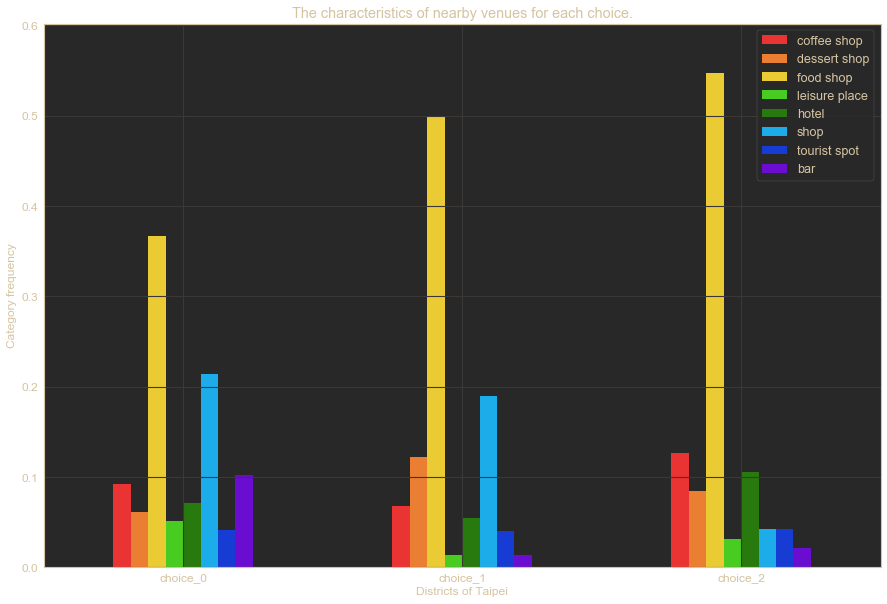

In [554]:
# Convert category types and add into a new column
v_df['category_2'] = v_df[['category']].apply( lambda x: cvtCategory( *x ), axis = 1 )

# Find out how many unique categories left from all the venues
print( "\nThere are {} unique categories in column 'category'".format( len( v_df['category'].unique() ) ) )
print( "There are {} unique categories in column 'category_2'.".format( len( v_df['category_2'].unique() ) ) )

# Remove the venues that are not in the new_category
v_df2 = v_df[v_df['category_2'].isin( new_category )]
print( "\nThe shape of original venue dataframe in expected category: {}".format( v_df.shape ) )
print( "The shape of new venue dataframe in expected category: {}".format( v_df2.shape ) )

# One hot encoding
v_onehot = pd.get_dummies( v_df2[['category_2']], prefix = "", prefix_sep = "" )

# Add choice column back to dataframe
v_onehot['choice'] = v_df['choice']
v_onehot['ori_category'] = v_df['category']

# Move district and category column to the first and second columns
fixed_columns = [v_onehot.columns[-2], v_onehot.columns[-1]] + list( v_onehot.columns[:-2] )
v_onehot = v_onehot[fixed_columns]

# Check the new dataframe tp_onehot
print( "v_onehot.shape = {}".format( v_onehot.shape ) )

# Group rows by choice and by taking the mean of the frequency of occurrence of each category which specified by us previously.
v_grouped = v_onehot.groupby( 'choice' ).mean().reset_index()

# Draw the bar plot to visualize the frequency distribution of venue categories for each choice.
import matplotlib.pyplot as plt
% matplotlib inline

colors = ['#ea3333','#ea7f33','#eacb33','#49cc21', '#287a0f','#1cacea','#173cd3','#6b0cd1']
ax = v_grouped[new_category].plot( kind = 'bar',
                                   title = "The characteristics of nearby venues for each choice.",
                                   figsize = ( 15, 10 ),
                                   legend = True,
                                   fontsize = 12,
                                   color = colors )
ax.set_xlabel( "Districts of Taipei", fontsize = 12 )
ax.set_ylabel( "Category frequency", fontsize = 12 )
ax.set_xticklabels( v_grouped['choice'], rotation = 0, fontsize = 12 )
ax.margins( 0.1 )
plt.show()

In [555]:
# Prepare the new column names
choice_columns = ['choice']
for idx in np.arange( len( new_category ) ):
    choice_columns.append( '{}_common_venue'.format( idx + 1 ) )

# Create a function to sort venues for Taipei districts respectively, and return lists of lists structure
def sort_rows_by_freq( data, columns ):
    res_list = []
    for idx in range( 0, data.shape[0], 1 ):
        data_sorted = data.loc[[idx], columns].sort_values( by = idx, ascending = False, axis = 1 )
        # Append the distrct name and its sorted venues
        res_list.append( list( data.loc[[idx], 'choice'].values ) + data_sorted.columns.tolist() )
    return res_list

# Execute venue sorting and store into a dataframe
v_temp_df = pd.DataFrame( sort_rows_by_freq( v_grouped, new_category ), columns = choice_columns )

# Join the sorted data into the original accommodation data_dict
v_df_joined = pd.DataFrame.from_dict( data_dict ).join( v_temp_df.set_index( 'choice' ), on = 'accommodation_choice' )
v_df_joined

,accommodation_choice,address,latitude,longitude,1_common_venue,2_common_venue,3_common_venue,4_common_venue,5_common_venue,6_common_venue,7_common_venue,8_common_venue
0,choice_0,"38, Songren Road, Xinyi District, Taipei City ...",25.037822,121.567956,food shop,shop,bar,coffee shop,hotel,dessert shop,leisure place,tourist spot
1,choice_1,"55, Lequn 2nd Road, Zhongshan District, Taipei...",25.080545,121.553787,food shop,shop,dessert shop,coffee shop,hotel,tourist spot,leisure place,bar
2,choice_2,Regent Taipei,25.054172,121.524227,food shop,coffee shop,hotel,dessert shop,shop,tourist spot,leisure place,bar


In [556]:
# Input your favorite category based on new_category when you are planning a trip.
print( new_category )

# Create a function to get the recommendation
def getRecommendation( favorite_category ):
    res_df = pd.DataFrame()
    for item in choice_columns[1:]:
        res_df = v_df_joined.loc[v_df_joined[item] == favorite_category]
        if not res_df.empty:
            break
    print( "\nYour favorite category: '{}', \nwe recommend: {}".format( favorite_category, res_df['address'].values ) )
    return res_df

# Suppose your favorite category is coffee shop
res_df = getRecommendation( 'coffee shop' )

# Visualize the recommended accommodations
map_accommodation = folium.Map( location = [c_latitude, c_longitude], zoom_start = 14 )

# Visualize the exploration neighborhoods of Foursqure
for choice, address, lat, lng in zip( res_df['accommodation_choice'], res_df['address'], res_df['latitude'], res_df['longitude'] ):
    label = "{}: {}".format( choice, address )
    label = folium.Popup( label, parse_html = True )
    folium.Marker( [lat, lng],
                   popup = label ).add_to( map_accommodation )
map_accommodation

['coffee shop', 'dessert shop', 'food shop', 'leisure place', 'hotel', 'shop', 'tourist spot', 'bar']

Your favorite category: 'coffee shop', 
we recommend: ['Regent Taipei']


## Result

#### 1. Analyze the districts in Taipei

In [560]:
# Distinctive venue distribution of each district
df_joined[['eng_name', 'venue_density'] + choice_columns[1:]]

,eng_name,venue_density,1_common_venue,2_common_venue,3_common_venue,4_common_venue,5_common_venue,6_common_venue,7_common_venue,8_common_venue
0,Beitou,69.387755,food shop,coffee shop,tourist spot,dessert shop,hotel,shop,leisure place,bar
1,Da'an,204.081633,food shop,coffee shop,shop,dessert shop,tourist spot,bar,leisure place,hotel
2,Datong,102.040816,food shop,shop,coffee shop,dessert shop,tourist spot,bar,leisure place,hotel
3,Nangang,59.183673,food shop,coffee shop,shop,dessert shop,hotel,leisure place,tourist spot,bar
4,Neihu,26.530612,food shop,shop,coffee shop,dessert shop,leisure place,hotel,tourist spot,bar
5,Shilin,138.775510,food shop,dessert shop,shop,coffee shop,leisure place,tourist spot,hotel,bar
6,Songshan,63.265306,food shop,shop,tourist spot,hotel,coffee shop,dessert shop,leisure place,bar
7,Wanhua,95.918367,food shop,dessert shop,shop,coffee shop,tourist spot,hotel,bar,leisure place
8,Wenshan,61.224490,food shop,coffee shop,shop,dessert shop,leisure place,tourist spot,hotel,bar
9,Xinyi,204.081633,food shop,shop,coffee shop,bar,tourist spot,dessert shop,leisure place,hotel


In [566]:
# Cluster 1 for Taipei
df_joined[df_joined['cluster_label'] == 0][['eng_name', 'cluster_label', 'venue_density'] + choice_columns[1:] ]

,eng_name,cluster_label,venue_density,1_common_venue,2_common_venue,3_common_venue,4_common_venue,5_common_venue,6_common_venue,7_common_venue,8_common_venue
2,Datong,0,102.040816,food shop,shop,coffee shop,dessert shop,tourist spot,bar,leisure place,hotel
5,Shilin,0,138.775510,food shop,dessert shop,shop,coffee shop,leisure place,tourist spot,hotel,bar
7,Wanhua,0,95.918367,food shop,dessert shop,shop,coffee shop,tourist spot,hotel,bar,leisure place
10,Zhongshan,0,114.285714,food shop,shop,hotel,coffee shop,dessert shop,tourist spot,leisure place,bar
11,Zhongzheng,0,124.489796,food shop,tourist spot,coffee shop,dessert shop,leisure place,shop,bar,hotel


In [565]:
# Cluster 2 for Taipei
df_joined[df_joined['cluster_label'] == 1][['eng_name', 'cluster_label', 'venue_density'] + choice_columns[1:]]

,eng_name,cluster_label,venue_density,1_common_venue,2_common_venue,3_common_venue,4_common_venue,5_common_venue,6_common_venue,7_common_venue,8_common_venue
0,Beitou,1,69.387755,food shop,coffee shop,tourist spot,dessert shop,hotel,shop,leisure place,bar
3,Nangang,1,59.183673,food shop,coffee shop,shop,dessert shop,hotel,leisure place,tourist spot,bar
4,Neihu,1,26.530612,food shop,shop,coffee shop,dessert shop,leisure place,hotel,tourist spot,bar
6,Songshan,1,63.265306,food shop,shop,tourist spot,hotel,coffee shop,dessert shop,leisure place,bar
8,Wenshan,1,61.224490,food shop,coffee shop,shop,dessert shop,leisure place,tourist spot,hotel,bar


In [564]:
# Cluster 3 for Taipei
df_joined[df_joined['cluster_label'] == 2][['eng_name', 'cluster_label', 'venue_density'] + choice_columns[1:]]

,eng_name,cluster_label,venue_density,1_common_venue,2_common_venue,3_common_venue,4_common_venue,5_common_venue,6_common_venue,7_common_venue,8_common_venue
1,Da'an,2,204.081633,food shop,coffee shop,shop,dessert shop,tourist spot,bar,leisure place,hotel
9,Xinyi,2,204.081633,food shop,shop,coffee shop,bar,tourist spot,dessert shop,leisure place,hotel


#### 2. Recommend the ordered accommodations from the aspect of the specified attributes

In [530]:
# With the accommodation list: accommodation_list.txt
# new_category:
#  ['coffee shop', 'dessert shop', 'food shop', 'leisure place', 'hotel', 'shop', 'tourist spot', 'bar']
for item in new_category:
    res_df = getRecommendation( item )


Your favorite category: 'coffee shop', 
we recommend: ['Regent Taipei']

Your favorite category: 'dessert shop', 
we recommend: ['55, Lequn 2nd Road, Zhongshan District, Taipei 10462, Taiwan']

Your favorite category: 'food shop', 
we recommend: ['38, Songren Road, Xinyi District, Taipei City Taiwan'
 '55, Lequn 2nd Road, Zhongshan District, Taipei 10462, Taiwan'
 'Regent Taipei']

Your favorite category: 'leisure place', 
we recommend: ['Regent Taipei']

Your favorite category: 'hotel', 
we recommend: ['Regent Taipei']

Your favorite category: 'shop', 
we recommend: ['38, Songren Road, Xinyi District, Taipei City Taiwan'
 '55, Lequn 2nd Road, Zhongshan District, Taipei 10462, Taiwan']

Your favorite category: 'tourist spot', 
we recommend: ['55, Lequn 2nd Road, Zhongshan District, Taipei 10462, Taiwan']

Your favorite category: 'bar', 
we recommend: ['38, Songren Road, Xinyi District, Taipei City Taiwan']


## Discussion

* We can found Datong, Shilin, Wanhua, Zhongshan, and Zhongzheng district are similar, which are classified as cluster 1.


* We can found Beitou, Nangong, Neihu, Songshan, and Wenshan district are similar, which are classified as cluster 2.


* We can found Da'an, and Xinyi district are similar, which are classified as cluster 3.


* From the clustering results, the parameter 'venue_density' have great impact on the clustering results canbe observed. The values of cluster 1 is around 115, around 55 for cluster 2, and around 204 for cluster 3.


* For the first objective, we can discover that all districts in Taipei are full of food to eat, which is in line with reality on purchasing food commodities in Taipei City, since the first common venue is "food shop" for all of them. Moreover, we also can found that the category "bar" is less than other category relatively in Taipei. If travelers who prefer walking along colorful markets, from the analysis results, Da'an or Xinyi district is recommended. While if travelers who focus on tourist spot, Zhongzheng, Beitou, or Songshan district may be more suitable for them comparing to other districts.


* For the second objective, we can input a list of accommodations in Taipei City, and then a suggestion based on our preference and the accommodation list will be shown.

## Conclusion

Using Pandas, Geopy, Foursquare APIs, we can capture quiet a few useful information to explore the characteristics of a region conveniently and achieve the goals of this project as follows:


##### 1. Analyze the districts in Taipei
##### 2. Recommend the ordered accommodations from the aspect of the specified attributes.


Moreover, Folium and Matplotlib are practical tools to visualize the structured data, which can be observed in the previous demonstrations.

As for the district analysis of Taipei City, the characteristics of each district and the results of K-means clustering are in line with the residents' perceptions even the data collected from a Wiki page and Foursquare database only. Hope in the future, the content of this project can be reorganized and modulized in a more systematic way for further use.